In [1]:
#This code gives you the stats for all models in the BCS_CNN folder, currently, it gives: Accuracy, precision, recall, F1 score, and MSE

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image as pil_image
import imageio
import tensorflow
import sklearn.metrics
import itertools
import seaborn as sn

from astropy.io import fits
import skimage.transform
import glob
import sklearn.metrics
import csv

import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import pytorch_lightning as pl
import torchmetrics
import torch
from torch import nn
from sklearn.utils import class_weight
import pandas as pd
import numpy as np
from datasets import load_dataset
model_type = 'VIT_models_best'


def normalize_Xtrain(X_train):
    mn = []
    mx = []
    Xn_train = np.zeros(np.shape(X_train))
    X_norm = np.zeros(np.shape(X_train))
    for i in range(len(X_train[0, ::])):
        mn.append(np.min(X_train[::, i]))
        Xn_train[::, i] = X_train[::, i] - mn[i]
    for i in range(len(X_train[0, ::])):
        mx.append(np.max(Xn_train[::, i]))
        if mx[i] == 0:
            X_norm[::, i] = 0
        if mx[i] != 0:
            X_norm[::, i] = Xn_train[::, i]/mx[i]
            
    return X_norm, mx, mn

with open(model_type+'_stats.csv', 'w', newline='') as file:
    writer = csv.writer(file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['Model', 'Accuracy', 'Precision', 'Weighted Precision', 'Recall', 'Weighted Recall', 'F1 Score', 'Weighted F1 Score', 'MSE'])

with open(model_type+'_stats_within_1.csv', 'w', newline='') as file:
    writer = csv.writer(file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['Model', 'Accuracy', 'Precision', 'Weighted Precision', 'Recall', 'Weighted Recall', 'F1 Score', 'Weighted F1 Score', 'MSE'])

c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pytorch_lightning as pl
from transformers import BeitForImageClassification, AdamW
import torch.nn as nn

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from transformers import BeitFeatureExtractor



feature_extractor = BeitFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
test_ds = load_dataset("DGE_test_mixed", data_dir="*/", split="train")

#For testing with a 70/30 split, use the below code, requires manually sorting the dataset into train/test/val splits:
#test_ds = load_dataset("DGE_all_10", data_dir="*/", split="train")

id2label = {id:label for id, label in enumerate(test_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
print(label2id)

from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor,
                                    RandomRotation)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [   
            #Resize(feature_extractor.size),
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples


trainer = Trainer(accelerator='gpu', devices=1,# callbacks=[early_stop_callback],#, checkpoint],
        check_val_every_n_epoch=1, 
        max_epochs=5,
        min_epochs=0,
        )

test_ds.set_transform(val_transforms)

from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_batch_size = 16
eval_batch_size = 8

test_dataloader = DataLoader(test_ds, collate_fn=collate_fn, batch_size=train_batch_size)

batch = next(iter(test_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

assert batch['pixel_values'].shape == (train_batch_size, 3, 224, 224)
assert batch['labels'].shape == (train_batch_size,)


class ViTLightningModule(pl.LightningModule):
    def __init__(self, num_labels=10):
        super(ViTLightningModule, self).__init__()
        self.vit = BeitForImageClassification.from_pretrained("microsoft/beit-base-patch16-224",
                                                              num_labels=5,
                                                              id2label=id2label,
                                                              label2id=label2id,
                                                              ignore_mismatched_sizes=True)

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        return outputs.logits
        
    def common_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        labels = batch['labels']
        logits = self(pixel_values)

        #criterion = nn.CrossEntropyLoss()
        criterion = nn.CrossEntropyLoss(weight=torch.cuda.FloatTensor(class_weights))
        loss = criterion(logits, labels)
        predictions = logits.argmax(-1)
        correct = (predictions == labels).sum().item()
        accuracy = correct/pixel_values.shape[0]

        return loss, accuracy
      
    def training_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        self.log("training_accuracy", accuracy)

        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss, on_epoch=True)
        self.log("validation_accuracy", accuracy, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)
        self.log("test_loss", loss, on_epoch=True)
        self.log("test_accuracy", accuracy, on_epoch=True)

        return loss, accuracy

    def configure_optimizers(self):
        # We could make the optimizer more fancy by adding a scheduler and specifying which parameters do
        # not require weight_decay but just using AdamW out-of-the-box works fine
        return AdamW(self.parameters(), lr=1e-5)

    # def train_dataloader(self):
    #     return train_dataloader

    # def val_dataloader(self):
    #     return val_dataloader
    
    def test_dataloader(self):
        return test_dataloader
    
    def predict_dataloader(self):
        return test_dataloader

Resolving data files: 100%|██████████| 760/760 [00:00<00:00, 379801.15it/s]
Using custom data configuration DGE_test_mixed-a8780ea480b8e1de
Reusing dataset imagefolder (C:\Users\zacha\.cache\huggingface\datasets\imagefolder\DGE_test_mixed-a8780ea480b8e1de\0.0.0\0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


{'2': 0, '3': 1, '4': 2, '5': 3, '6': 4}
pixel_values torch.Size([16, 3, 224, 224])
labels torch.Size([16])


c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\nump

Beginning of results for  BEiT_64_k -------------------------------------------------------

The accuracy of  BEiT_64_k  is:  0.6434210526315789

Model precision is:  0.37854032759693135
Model weighted precision is:  0.6415963257199603

Model recall is:  0.4022607711347412
Model weighted recall is:  0.6434210526315789

Model f1_score is:  0.3782465167436856
Model weighted f1_score is:  0.6217440489290058

Model MSE is:  1.6513157894736843



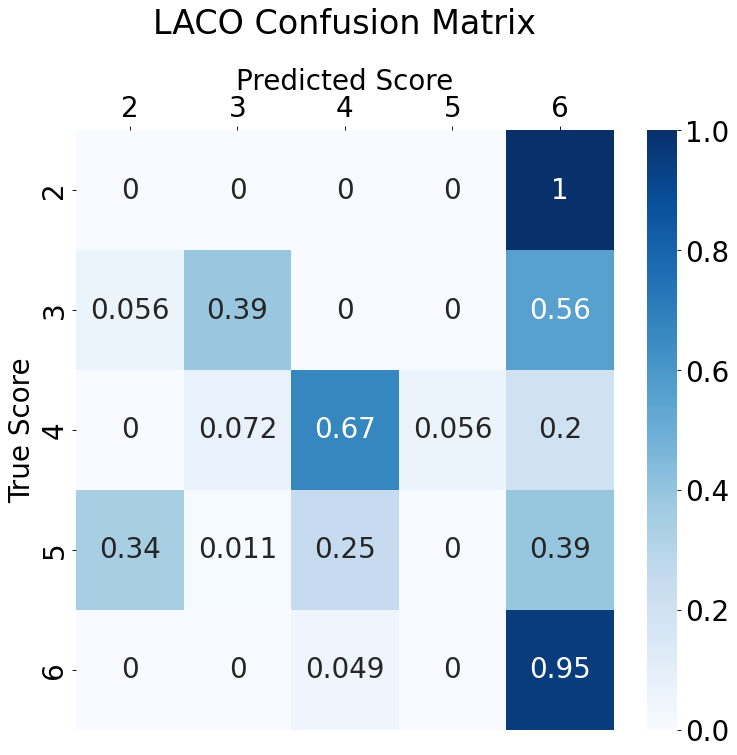

****Error within 1 results starts now****

The accuracy of  BEiT_64_k  within 1 is:  0.7842105263157895



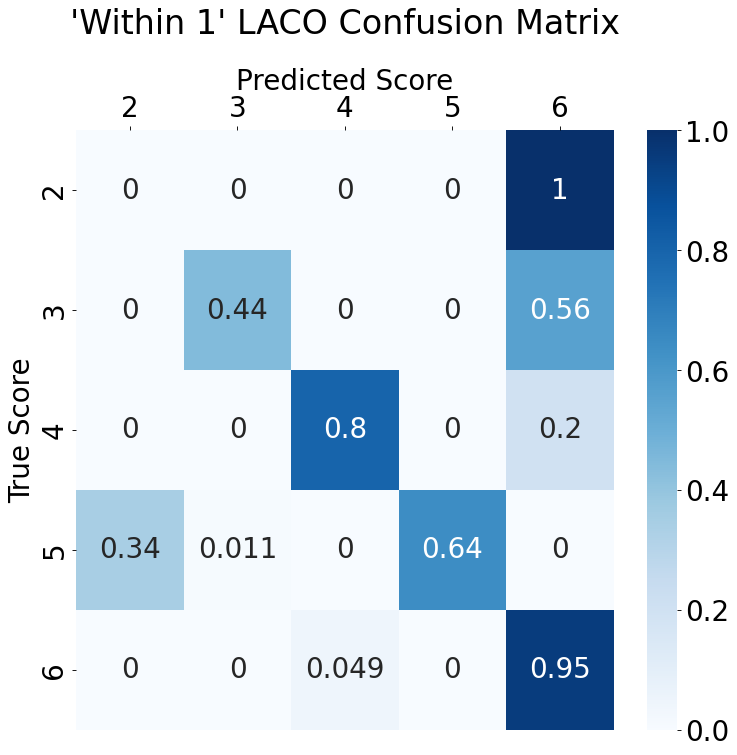

Model unweighted precision is:  0.7125451571178575
Model weighted precision is:  0.8509635652558697

Model unweighted recall is:  0.5675717054111928
Model weighted recall is:  0.7842105263157895

Model unweighted f1_score is:  0.6056614610415366
Model weighted f1_score is:  0.7933647704876651



In [3]:
# new_model = ViTLightningModule.load_from_checkpoint(checkpoint_path="VIT_models\BEiT_64_keep.ckpt")
# trainer.test(model=new_model, dataloaders=test_dataloader, verbose=True)

model_names = glob.glob('BCS_CNN\\' + model_type + '\\*')

for model_name in model_names:
    model = ViTLightningModule.load_from_checkpoint(checkpoint_path=model_name)
    #model = load_model(model_name)
    # data_set_type = model_name[len('BCS_CNN\VGG16\VGG16_'):-8] #For VGG16
    # name = str(model_name[len('BCS_CNN\VGG16\\'):-8]) #For VGG16
    # data_set_type = model_name[len('BCS_CNN\SqueezeNet\SqueezeNet_'):-8] #for Squeezenet
    # name = str(model_name[len('BCS_CNN\SqueezeNet\\'):-8]) #For SqueezeNet
    data_set_type = model_name[len('BCS_CNN/' + model_type + '/' + model_type + '_'):-8]
    name = str(model_name[len('BCS_CNN/' + model_type + '/'):-8]) 
    # print(data_set_type)
    # print(name)
    # test_data = 'test_data_' + data_set_type + '.csv'
    # print(test_data)

    #test_df = pd.read_csv(test_data,dtype=str)
    # #test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    # test_datagen = ImageDataGenerator(fill_mode = "reflect", data_format = "channels_last")
    # test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,\
    #                                             directory = '',\
    #                                             xcol='filename',ycol='class',\
    #                                             target_size=(224,224), color_mode='rgb',\
    #                                             batch_size=128, class_mode='categorical',\
    #                                             shuffle=False)

    # train_data = 'train_data_' + data_set_type + '.csv'
    # train_df = pd.read_csv(train_data,dtype=str)
    #train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    # train_datagen = ImageDataGenerator(fill_mode = "reflect", data_format = "channels_last")
    # train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,\
    #                                                 directory='',\
    #                                                 xcol='filename',y_col='class',\
    #                                                 target_size=(224,224), color_mode='rgb',\
    #                                                 batch_size=128, class_mode='categorical',\
    #                                                 shuffle=False)


    # adam_opt = Adam(learning_rate=0.001)
    # model.compile(loss='categorical_crossentropy', optimizer=adam_opt,\
    #            metrics=['categorical_accuracy'])
    # Y_test_hat=model.predict(test_generator)
    # y_test_hat=Y_test_hat.argmax(axis=-1)+2

    # Y_train_hat=model.predict(train_generator)
    # y_train_hat=Y_train_hat.argmax(axis=-1)+2
    y_pred = []
    y_true = []
    model.to('cuda')
    model.eval()
    for batch in test_dataloader:
        labels = batch['labels'].to('cuda')
        outputs = model(batch['pixel_values'].type('torch.cuda.FloatTensor'))
        predictions=np.argmax(outputs.cpu().detach().numpy(), axis=-1)
        y_pred.append(predictions)
        y_true.append(labels.cpu().detach().numpy())

    # y_test = y_true
    # y_test_hat = y_pred

    y_true_total = []
    for i in range(np.shape(y_true)[0]):
        for j in range(len(y_true[i])):
            y_true_total.append(y_true[i][j])

    y_pred_total = []
    for i in range(np.shape(y_pred)[0]):
        for j in range(len(y_pred[i])):
            y_pred_total.append(y_pred[i][j])
    
    y_test = y_true_total
    y_test_hat = y_pred_total
    # y_test = test_df['class']
    # y_test = [int(i) for i in y_test]

    # y_train = train_df['class']
    # y_train = [int(i) for i in y_train]

    print('Beginning of results for ', name, '-------------------------------------------------------')
    print()

    con_matrix = sklearn.metrics.confusion_matrix(y_test,y_test_hat, normalize='true')
    con_matrix2 = sklearn.metrics.confusion_matrix(y_test,y_test_hat)
    acc=np.diag(con_matrix2).sum().astype(float)/con_matrix2.sum()

    # con_matrix_train = sklearn.metrics.confusion_matrix(y_train,y_train_hat)
    # acc_train=np.diag(con_matrix_train).sum().astype(float)/con_matrix_train.sum()


    print('The accuracy of ', name,' is: ', acc)
    print()
    # print('The train accuracy of ', name,' is: ', acc_train)
    # print()

    # min = np.min(con_matrix)
    # max = np.max(con_matrix)
    # temp_mat = con_matrix - min
    # temp_mat = con_matrix/max


    #Metrics
    precision = sklearn.metrics.precision_score(y_test,y_test_hat, average='macro', zero_division=1)
    print('Model precision is: ', precision)
    precision_weighted = sklearn.metrics.precision_score(y_test,y_test_hat, average='weighted', zero_division=1)
    print('Model weighted precision is: ', precision_weighted)
    print()

    recall = sklearn.metrics.recall_score(y_test,y_test_hat, average='macro')
    print('Model recall is: ', recall)
    recall_weighted = sklearn.metrics.recall_score(y_test,y_test_hat, average='weighted')
    print('Model weighted recall is: ', recall_weighted)
    print()

    f1_score = sklearn.metrics.f1_score(y_test,y_test_hat, average='macro')
    print('Model f1_score is: ', f1_score)
    f1_score_weighted = sklearn.metrics.f1_score(y_test,y_test_hat, average='weighted')
    print('Model weighted f1_score is: ', f1_score_weighted)
    print()


    MSE = sklearn.metrics.mean_squared_error(y_test,y_test_hat)
    print('Model MSE is: ', MSE)
    print()


    plt.rcParams.update({'font.size': 25})

    
    df_cm = pd.DataFrame(con_matrix, index = range(0, 5),
                     columns = range(0, 5))

    fig = plt.figure(figsize=(10,10), dpi=80)
    ax = sn.heatmap(con_matrix, annot=True, xticklabels=[2, 3, 4, 5, 6], yticklabels=[2, 3, 4, 5, 6], cmap='Blues')
    ax.xaxis.tick_top()
    ax.set_xlabel('Predicted Score')    
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('True Score') 
    #sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_true_total, y_pred_total, display_labels=[2, 3, 4, 5, 6], cmap='gray', colorbar=False)
    plt.title('LACO Confusion Matrix', y=1.15)#, x=0.6)
    fig.tight_layout()
    plt.savefig('Figures\LACO_confusion_matrix.png', format='png', bbox_inches='tight') 
    plt.show()


    # plt.figure(figsize=(10,10))
    # plt.imshow(normalize_Xtrain(con_matrix2)[0], cmap='gray')
    # plt.title('Confusion Matrix for '+ name + f'{acc:.2f}, {precision:.2f}, {recall:.2f}, {f1_score:.2f}, Exact Matches')
    # plt.xticks(list(range(len(['2', '3', '4', '5', '6']))), ['2', '3', '4', '5', '6'])
    # plt.yticks(list(range(len(['2', '3', '4', '5', '6']))), ['2', '3', '4', '5', '6'])
    # plt.ylabel('True Labels')
    # plt.xlabel('Predicted Labels')


    print('****Error within 1 results starts now****')
    print()





    y_within_1 = []
    for i in range(0, len(y_test)):
        if ((y_test_hat[i] == y_test[i]+1) or (y_test_hat[i] == y_test[i]-1) or (y_test_hat[i] == y_test[i])):
            y_within_1.append(y_test[i])
        else:
            y_within_1.append(y_test_hat[i])


    con_matrix = sklearn.metrics.confusion_matrix(y_test,y_within_1, normalize='true')
    con_matrix2 = sklearn.metrics.confusion_matrix(y_test,y_within_1)
    acc_1=np.diag(con_matrix2).sum().astype(float)/con_matrix2.sum()


    print('The accuracy of ', name, ' within 1 is: ', acc_1)
    print()

    # min = np.min(con_matrix)
    # max = np.max(con_matrix)
    # temp_mat = con_matrix - min
    # temp_mat = con_matrix/max

    # plt.figure(figsize=(10,10))
    # plt.imshow(normalize_Xtrain(con_matrix2)[0], cmap='gray')
    # plt.title('Confusion Matrix for '+ name + ' Error of 1')
    # plt.xticks(list(range(len(['2', '3', '4', '5', '6']))), ['2', '3', '4', '5', '6'])
    # plt.yticks(list(range(len(['2', '3', '4', '5', '6']))), ['2', '3', '4', '5', '6'])
    # plt.ylabel('True Labels')
    # plt.xlabel('Predicted Labels')


    plt.rcParams.update({'font.size': 25})

    
    df_cm = pd.DataFrame(con_matrix, index = range(0, 5),
                     columns = range(0, 5))

    fig = plt.figure(figsize=(10,10), dpi=80)
    ax = sn.heatmap(con_matrix, annot=True, xticklabels=[2, 3, 4, 5, 6], yticklabels=[2, 3, 4, 5, 6], cmap='Blues')
    ax.xaxis.tick_top()
    ax.set_xlabel('Predicted Score')    
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('True Score') 
    #sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_true_total, y_pred_total, display_labels=[2, 3, 4, 5, 6], cmap='gray', colorbar=False)
    plt.title("'Within 1' LACO Confusion Matrix", y=1.15)#, x=0.6)
    fig.tight_layout()
    plt.savefig('Figures\LACO_confusion_matrix_error_of_1.png', format='png', bbox_inches='tight') 
    plt.show()

    
    #Metrics
    precision_1 = sklearn.metrics.precision_score(y_test,y_within_1, average='macro', zero_division=1)
    print('Model unweighted precision is: ', precision_1)
    precision_weighted_1 = sklearn.metrics.precision_score(y_test,y_within_1, average='weighted', zero_division=1)
    print('Model weighted precision is: ', precision_weighted_1)
    print()

#print('Avg :', sklearn.metrics.accuracy_score(y_test, y_test_hat, normalize=False))

    recall_1 = sklearn.metrics.recall_score(y_test,y_within_1, average='macro')
    print('Model unweighted recall is: ', recall_1)
    recall_weighted_1 = sklearn.metrics.recall_score(y_test,y_within_1, average='weighted')
    print('Model weighted recall is: ', recall_weighted_1)
    print()

    f1_score_1 = sklearn.metrics.f1_score(y_test,y_within_1, average='macro')
    print('Model unweighted f1_score is: ', f1_score_1)
    f1_score_weighted_1 = sklearn.metrics.f1_score(y_test,y_within_1, average='weighted')
    print('Model weighted f1_score is: ', f1_score_weighted_1)
    print()


    with open(model_type+'_stats.csv', 'a+', newline='') as file:
        writer = csv.writer(file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
        writer.writerow([name.replace('_', ' '), str(round(acc, 2)), round(precision, 2), round(precision_weighted, 2), round(recall, 2), round(recall_weighted, 2), round(f1_score, 2), round(f1_score_weighted, 2), round(MSE, 2)])

    with open(model_type+'_stats_within_1.csv', 'a+', newline='') as file:
        writer = csv.writer(file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
        writer.writerow([name.replace('_', ' '), str(round(acc_1, 2)), round(precision_1, 2), round(precision_weighted_1, 2), round(recall_1, 2), round(recall_weighted_1, 2), round(f1_score_1, 2), round(f1_score_weighted_1, 2)])

    # MSE = sklearn.metrics.mean_squared_error(y_test,y_test_hat)
    # print('Model MSE is: ', MSE)
    # print()
    # print()
    # print(model.summary())
    # print()

